In [25]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate

from astropy.cosmology import FlatLambdaCDM
import GPy
import os, sys
sys.path.append('../code')
from photoz_kernels import *
import seaborn as sns
sns.set_style("white")

In [22]:
alpha_C = 3e3
alpha_L = 1e0
alpha_T = 0.2
V_C = 2e3
V_L = 2e3

max_redshift = 2.0
ab_filters = ['u', 'g', 'r', 'i', 'z']
numBands = len(ab_filters)
amp_arr = np.genfromtxt('filter_gaussian_coefficients_amp_'+''.join(ab_filters)+'.txt')
mu_arr = np.genfromtxt('filter_gaussian_coefficients_mu_'+''.join(ab_filters)+'.txt')
sig_arr = np.genfromtxt('filter_gaussian_coefficients_sig_'+''.join(ab_filters)+'.txt')
numCoefs = amp_arr.shape[0]
lines_mu = np.array([ 3732.22, 5002.26, 1392.07, 1542.91, 2009.82, 2384.11, 2795.42, 
                     3174.70, 4858.05, 5401.32, 6292.06, 6556.74, 6719.12, 8775.69, 
                     3253.81, 3372.75, 3528.47, 3870.62, 4104.03, 4343.24, 5308.43, 
                     6853.21, 7027.87, 7134.49, 7227.85, 9065.54, 9230.14, 9527.33, 
                     9603.17, 1213.04, 3835.44, 3969.87 ])
lines_sig = np.array([ 23.11, 34.10, 6.41, 5.58, 22.81, 2.63, 11.14, 3.90, 3.68, 
                      11.83, 3.18, 4.39, 10.70, 6.77, 5.33, 2.14, 4.74, 9.18, 
                      7.03, 8.57, 4.43, 2.49, 11.83, 3.84, 3.13, 4.99, 4.52, 
                      5.01, 5.04, 8.20, 2.46, 2.93 ])
print lines_mu.size, lines_sig.size

k = Photoz(amp_arr, mu_arr, sig_arr, lines_mu, lines_sig, V_C, V_L, alpha_C, alpha_L, alpha_T)

32 32


In [23]:
xx, yy = np.mgrid[0:4:5j, 0:2:20j]
X = np.vstack((0*xx.flatten(), xx.flatten(), yy.flatten())).T
K = k.K(X)

 /Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning:covariance is not positive-semidefinite.


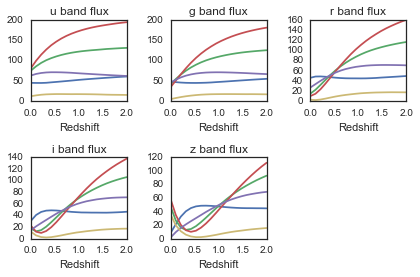

In [24]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=False, sharey=False)
axs = axs.ravel()

for i in range(5):
    s = np.random.multivariate_normal(np.zeros(X.shape[0]), K)
    for jf in range(5):
        ind = X[:,1].astype(int) == jf
        s -= 1.1*np.min([np.min(s),0])
        axs[jf].plot(X[ind,2], s[ind]) 
for jf in range(5):
    axs[jf].set_title(ab_filters[jf]+' band flux')
    axs[jf].set_xlabel('Redshift')
for jf in range(5, axs.size):
    axs[jf].set_axis_off()
fig.tight_layout()
fig.savefig('pics/Photoz_curves_draws.pdf')

In [61]:
k = GPy.kern.RBF(input_dim=3)
K = k.K(X)

 /Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning:covariance is not positive-semidefinite.


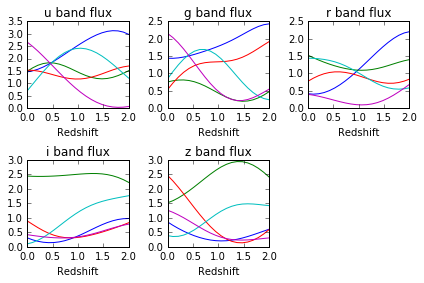

In [63]:
fig, axs = plt.subplots(2, 3, figsize=(6, 4), sharex=False, sharey=False)
axs = axs.ravel()

for i in range(5):
    s = np.random.multivariate_normal(np.zeros(X.shape[0]), K)
    for jf in range(5):
        ind = X[:,1].astype(int) == jf
        s -= 1.1*np.min([np.min(s),0])
        axs[jf].plot(X[ind,2], s[ind]) 
for jf in range(5):
    axs[jf].set_title(ab_filters[jf]+' band flux')
    axs[jf].set_xlabel('Redshift')
for jf in range(5, axs.size):
    axs[jf].set_axis_off()
fig.tight_layout()
fig.savefig('pics/Photoz_curves_draws_RBF.pdf')

In [133]:
noise = 1e-1
X = -1 + 2*np.random.rand(5)
Y = np.cos(X)*X + noise * np.random.randn(X.shape[0])

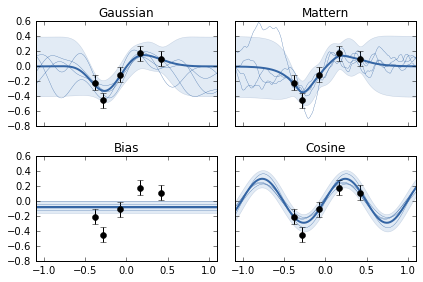

In [134]:
fig, axs = plt.subplots(2, 2, figsize=(6, 4), sharex=True, sharey=True)
axs = axs.ravel()

kernels = [GPy.kern.RBF(input_dim=1),
          GPy.kern.Matern32(input_dim=1),
          GPy.kern.Bias(input_dim=1),
          GPy.kern.Cosine(input_dim=1)]
names = ['Gaussian', 'Mattern', 'Bias', 'Cosine']

for i, k in enumerate(kernels):
    m = GPy.models.GPRegression(X[:,None], Y[:,None], kernel=k)
    m.likelihood.variance.fix(noise**2)
    m.optimize()
    m.plot_f(ax=axs[i], plot_data=True, samples=4, legend=False, plot_limits=[-1.1,1.1])#, lower=16, upper=84
    axs[i].errorbar(X, Y, yerr=0*Y+noise, fmt="o", c='k')
    axs[i].set_title(names[i])
    #axs[i].set_ylim([-1,1])


fig.tight_layout()
fig.savefig('Kernels.pdf')

In [30]:
from astropy.io import fits
from astropy.table import Table, join, hstack, unique
import sys
from corner import hist2d
import os

fulldata = Table.read('/Users/bl/Dropbox/Uband/y3_u_coadd.fits')
fulldata['z_spec'][fulldata['z_spec'] == 1.00] = -1
fulldata['mag_auto_u'] += 1.25
print np.sum(fulldata['z_spec'] > 0)
print np.sum(fulldata['info']==0)
cuts = fulldata['flags_gold'] == 0
#cuts &= fulldata['has_gold_match'] == 1
cuts &= fulldata['modest_class'] == 1
cuts &= fulldata['info'] == 0
#cuts &= info == 0
cuts &= fulldata['flags_badregion'] == 0
cuts &= fulldata['coadd_objects_id'] > 0
print np.sum(cuts)
bands = ['u', 'g', 'r', 'i', 'z']#, 'y'
nb = len(bands)
for i in range(nb-1):
    #mag1 = 30 - 2.5*np.log10(fulldata['flux_auto_'+bands[i]])
    #mag2 = 30 - 2.5*np.log10(fulldata['flux_auto_'+bands[j]])
    mag1 = fulldata['mag_auto_'+bands[i+1]]
    mag2 = fulldata['mag_auto_'+bands[i]]
    fobs = mag1 - mag2
    err = np.sqrt(fulldata['magerr_auto_'+bands[i+1]]**2 + fulldata['magerr_auto_'+bands[i]]**2)
    cuts &= fobs > -3.0
    cuts &= fobs < 0.5
    cuts &= err < 1.1
#photocuts = np.random.choice(np.where(cuts)[0], 1e4, replace=False)
photocuts = np.where(cuts)[0]
#speccuts = np.where(fulldata['has_spec_match'][photocuts] == 1)[0]
speccuts = np.where(fulldata['z_spec'][photocuts] > 0)[0]
print 'Objects passing cuts without specz:', photocuts.size, ', and with specz:', speccuts.size
data = fulldata[photocuts]

22066
184643
124793
Objects passing cuts without specz: 120174 , and with specz: 15320


 /Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:29: RuntimeWarning:invalid value encountered in greater
 /Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: RuntimeWarning:invalid value encountered in less
 /Users/bl/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:31: RuntimeWarning:invalid value encountered in less


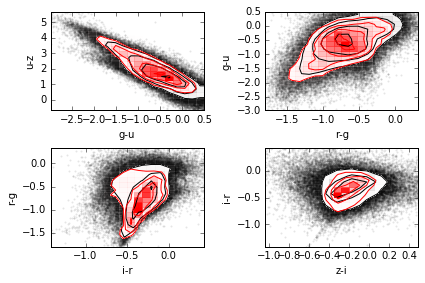

In [31]:
fig, axs = plt.subplots(2, 2)
axs = axs.ravel()
off = 0
from corner import hist2d
for i in range(nb-1):
    mag1 = fulldata['mag_auto_'+bands[i+1]][photocuts] - fulldata['mag_auto_'+bands[i]][photocuts]
    for j in range(i-1, i):
        mag2 = fulldata['mag_auto_'+bands[j+1]][photocuts] - fulldata['mag_auto_'+bands[j]][photocuts]
        hist2d(mag1, mag2, ax=axs[off])
        hist2d(mag1[speccuts], mag2[speccuts], ax=axs[off], color='r', plot_datapoints=False)
        axs[off].set_xlabel(bands[i+1]+'-'+bands[i])
        axs[off].set_ylabel(bands[j+1]+'-'+bands[j])
        off += 1 
fig.tight_layout()

In [46]:
#data1 = np.genfromtxt('/Users/bl/Dropbox/Astrodata/DES/WLphotoz/bccufig_subsample/bccufig_subsample_matchedngmixcolours_extracuts_autoerrz.txt',
#                     names='mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, z_spec_0')
data1 = np.genfromtxt('/Users/bl/Dropbox/Astrodata/DES/WLphotoz/bccufig_subsample/bccufig_subsample_autoerrz.txt',
    names='mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, z_spec_0')

In [36]:
data2 = np.genfromtxt('/Users/bl/Dropbox/Astrodata/DES/WLphotoz/bccufig_subsample/train_sns_main_deep_2.1_small.txt',
                     names='mag_auto_g, mag_auto_r, mag_auto_i, mag_auto_z, magerr_auto_g, magerr_auto_r, magerr_auto_i, magerr_auto_z, g-r, g-i, g-z, r-i, r-z, i-z, z_spec_0')
data2

array([ (22.813164, 22.219903, 22.007349, 22.216238, 0.0621, 0.0476, 0.066, 0.1288, 0.593261, 0.805814, 0.596926, 0.212554, 0.003665, -0.208888, 0.5197),
       (24.17092, 23.755671, 23.704339, 23.269716, 0.1183, 0.1254, 0.1221, 0.2652, 0.415249, 0.466581, 0.901204, 0.051332, 0.485955, 0.434623, 1.5259),
       (24.158542, 23.209786, 22.690566, 22.572578, 0.1191, 0.0609, 0.0738, 0.1213, 0.948756, 1.467976, 1.585965, 0.51922, 0.637208, 0.117988, 0.6695),
       ...,
       (23.033453, 22.081197, 21.63905, 21.422823, 0.0729, 0.0435, 0.0522, 0.0897, 0.952256, 1.394402, 1.610629, 0.442146, 0.658373, 0.216227, 0.61317),
       (21.601948, 21.005756, 20.898759, 20.671477, 0.0399, 0.0289, 0.041, 0.0603, 0.596193, 0.703189, 0.930471, 0.106997, 0.334278, 0.227282, 0.38587),
       (21.690123, 21.296588, 21.117381, 21.069538, 0.0194, 0.017, 0.0213, 0.0387, 0.393535, 0.572742, 0.620585, 0.179207, 0.22705, 0.047843, 0.14302)], 
      dtype=[('mag_auto_g', '<f8'), ('mag_auto_r', '<f8'), ('mag_auto_

In [77]:
template_names = ['El_B2004a', 'Sbc_B2004a', 'Scd_B2004a', 'Im_B2004a', 'SB3_B2004a', 'SB2_B2004a', 'ssp_25Myr_z008', 'ssp_5Myr_z008']
bands = ['g', 'r', 'i', 'z']
redshiftGrid = np.linspace(0, 2.0, num=50)
nt = len(template_names)
nf = len(bands)
nz = redshiftGrid.size

import sys
sys.path.append("/Users/bl/Dropbox/software/bpz-1.99.3")
from bpz_tools import lf_z_sed

f_mod = np.zeros((nz, nt, nf))*0.
for it in range(nt):         
    for jf in range(nf):                            
        f_mod[:,it,jf] = lf_z_sed(template_names[it], bands[jf], z=redshiftGrid, ccd='yes', units='lambda', madau='yes')

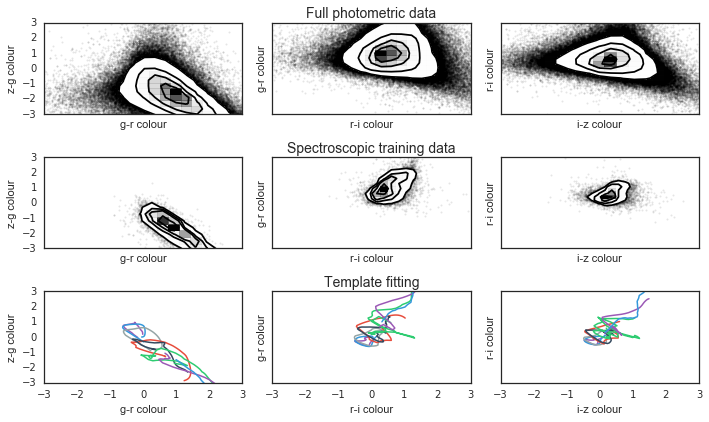

In [132]:

sns.set_palette(sns.color_palette("hls", 8))
palette = sns.color_palette()

flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71", "#9b59b6", "#3498db"]
sns.set_style("white")
sns.set_palette(sns.color_palette(flatui))
from corner import hist2d
from matplotlib.colors import LogNorm


fig, axs = plt.subplots(3, 3, figsize=(10, 6), sharex=True, sharey=True)
#axs = axs.ravel()
off = 0
nb = len(bands)
for i in range(nb-1):
    mag1 = - data1['mag_auto_'+bands[i+1]] + data1['mag_auto_'+bands[i]]
    mag1b = - data2['mag_auto_'+bands[i+1]] + data2['mag_auto_'+bands[i]]
    magt1 = f_mod[:,:,i] - f_mod[:,:,i+1]
    for j in range(i-1, i):
        mag2 = - data1['mag_auto_'+bands[j+1]] + data1['mag_auto_'+bands[j]]
        mag2b = - data2['mag_auto_'+bands[j+1]] + data2['mag_auto_'+bands[j]]
        magt2 = f_mod[:,:,j] - f_mod[:,:,j+1]
        
        #axs[off].hist2d(mag1, mag2, 40, cmap='Greys')
        levels = 1.0 - np.exp(-0.5 * np.arange(0.5, 2.6, 0.5) ** 2)
        hist2d(mag1b, mag2b, ax=axs[1,off], lw=2, color='k', alpha=0.5, levels=levels)
        hist2d(mag1, mag2, 40, ax=axs[0,off], color='k', alpha=0.5, levels=levels)
        for k in range(3):
            axs[k,off].set_xlabel(bands[i]+'-'+bands[i+1]+' colour')
            axs[k,off].set_ylabel(bands[j]+'-'+bands[j+1]+' colour')
            axs[k,off].set_xlim([-3,3])
            axs[k,off].set_ylim([-3,3])
        for t in range(nt):
            axs[2,off].plot(magt1[:,t], magt2[:,t], color=flatui[t], lw=1.5)
            #axs[1,off].plot(magt1[:,t], magt2[:,t], color='b', lw=1)
        off += 1 

axs[0,1].set_title('Full photometric data', fontsize=14)
axs[1,1].set_title('Spectroscopic training data', fontsize=14)
axs[2,1].set_title('Template fitting', fontsize=14)
fig.tight_layout()
fig.savefig('photovsspec.pdf')